In [8]:
import pandas as pd 
import numpy as np
import seaborn as sns

from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
from sklearn.svm import SVC

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, classification_report

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pickle
from imblearn.over_sampling import SMOTE


In [9]:
df=pd.read_csv('../data/wine_quality_modelos2.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   wine_type             6497 non-null   object 
 1   fixed acidity         6497 non-null   float64
 2   volatile acidity      6497 non-null   float64
 3   citric acid           6497 non-null   float64
 4   residual sugar        6497 non-null   float64
 5   chlorides             6497 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6497 non-null   float64
 10  sulphates             6497 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
 13  quality_category      6497 non-null   object 
dtypes: float64(11), int64(1), object(2)
memory usage: 710.7+ KB


In [5]:
# Separamos las features de las etiquetas 
# X = df[['fixed acidity','volatile acidity','citric acid','residual sugar','chlorides', 'total sulfur dioxide', 'density', 'pH','sulphates','alcohol']]
X = df[['volatile acidity','total sulfur dioxide', 'density', 'pH','alcohol']]
y = df["quality_category"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10, stratify=y)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(5197, 5)
(5197,)
(1300, 5)
(1300,)


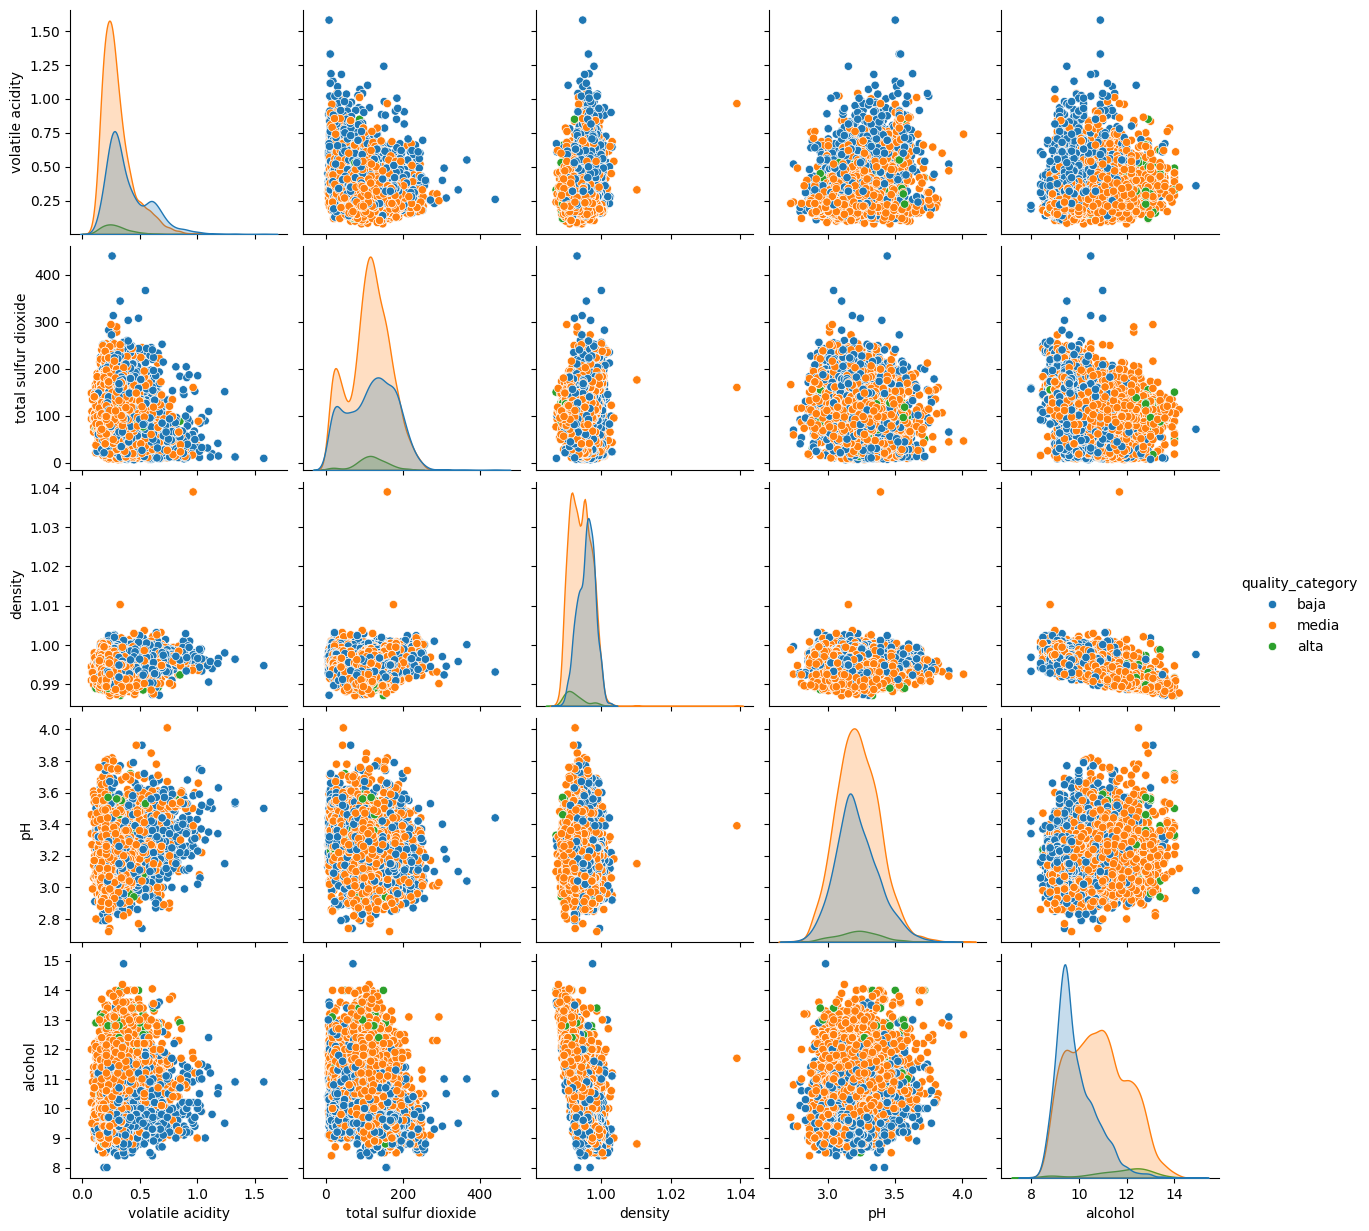

In [6]:
sns.pairplot(df, vars=X, hue='quality_category')

In [ ]:
'''
df_resampled = pd.DataFrame(X_res, columns=X.columns)
df_resampled['quality_category'] = y_res  # Añade la columna target
df_resampled.to_csv('../data/wine_quality_modelos4.csv') 
'''

In [10]:
# Guardar scaler por separado
scaler = StandardScaler().fit(X_train)
with open('../models/scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

In [61]:
# Escalamos los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [62]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

In [63]:

from sklearn.ensemble import AdaBoostClassifier

dt = DecisionTreeClassifier(max_depth=12)

modelo_abc = AdaBoostClassifier(
    estimator=dt, 
    n_estimators=150, 
    learning_rate=0.5,
    random_state=10)
 
modelo_abc.fit(X_train_resampled, y_train_resampled)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=12),
                   learning_rate=0.5, n_estimators=150, random_state=10)

In [64]:

y_pred_abc = modelo_abc.predict(X_test_scaled)
y_proba_abc = modelo_abc.predict_proba(X_test_scaled) 

In [ ]:
# 1. Métricas básicas
print("Accuracy:", accuracy_score(y_test, y_pred_abc))
print("Precision (macro):", precision_score(y_test, y_pred_abc, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred_abc, average='macro'))
print("F1-Score (macro):", f1_score(y_test, y_pred_abc, average='macro'))
accu_abc=accuracy_score(y_test, y_pred_abc)

# 2. Matriz de confusión
print("\nMatriz de Confusión:")
print(confusion_matrix(y_test, y_pred_abc)) 
cm_rf_abc = confusion_matrix(y_test, y_pred_abc)


# 4. Reporte completo por clase
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_abc))

# 4. ROC-AUC (para multiclase) 
if len(modelo_abc.classes_) > 2:
    y_test_bin = pd.get_dummies(y_test).values  # One-hot encoding
    roc_auc_abc=roc_auc_score(y_test_bin, y_proba_abc, multi_class='ovr')
else:
    print("ROC-AUC (Binario):", roc_auc_score(y_test, y_proba_abc[:, 1]))
print ('ROC _ AUC')    
roc_auc_abc

Accuracy: 0.7930769230769231
Precision (macro): 0.6884840330568892
Recall (macro): 0.6214786300071488
F1-Score (macro): 0.6454440357780405

Matriz de Confusión:
[[ 11   0  29]
 [  0 350 127]
 [ 12 101 670]]

Reporte de Clasificación:
              precision    recall  f1-score   support

        alta       0.48      0.28      0.35        40
        baja       0.78      0.73      0.75       477
       media       0.81      0.86      0.83       783

    accuracy                           0.79      1300
   macro avg       0.69      0.62      0.65      1300
weighted avg       0.79      0.79      0.79      1300

ROC _ AUC


np.float64(0.8917342290625161)

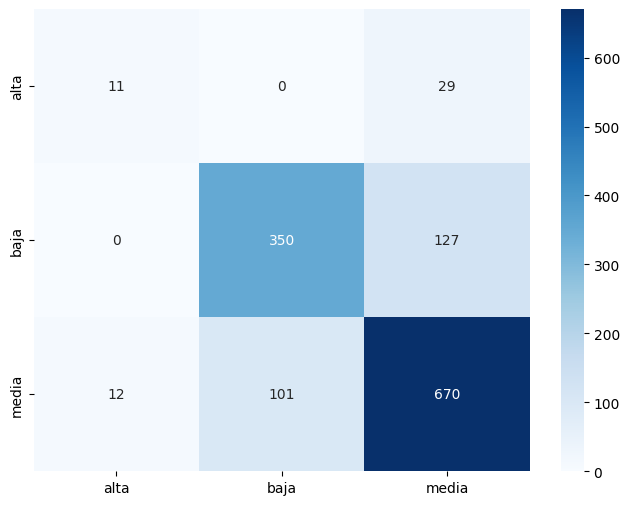

In [66]:
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(
    cm_rf_abc, 
    annot=True, 
    fmt='d',          # 'd' = formato entero (sin decimales)
    cmap='Blues',     # Colores azules (puedes usar 'Reds', 'Greens', etc.)
    cbar=True,        # Muestra la barra de colores lateral
    xticklabels=['alta', 'baja', 'media'],  # Nombres de clases (¡ajústalos!)
    yticklabels=['alta', 'baja', 'media'] # Nombres de clases
)

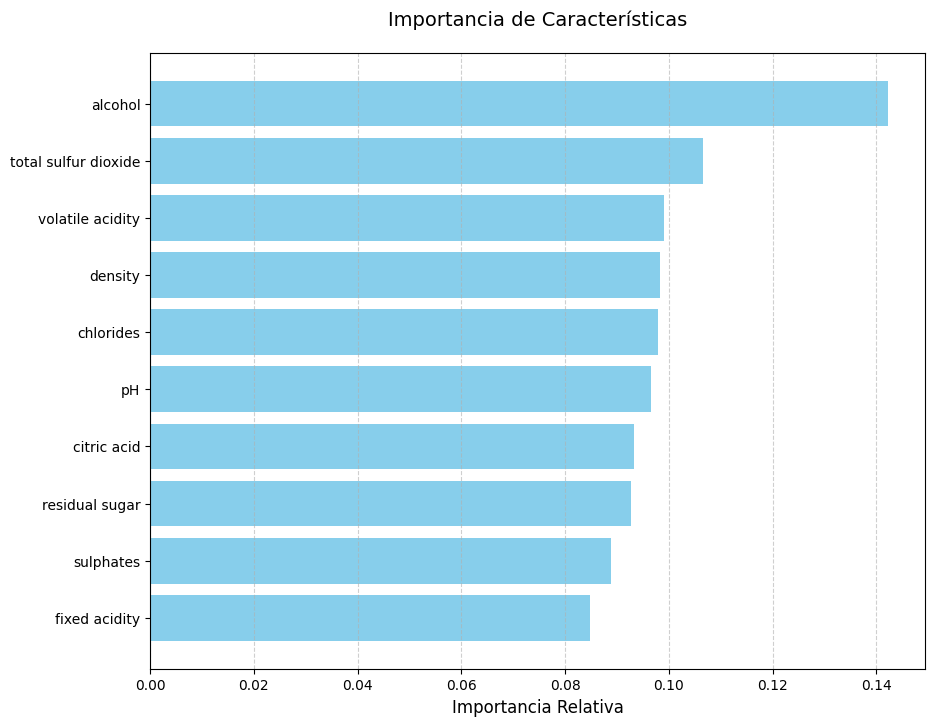

In [67]:
importances = modelo_abc.feature_importances_
feature_names = ['fixed acidity','volatile acidity','citric acid','residual sugar', 
        'chlorides', 'total sulfur dioxide', 'density', 'pH','sulphates','alcohol'] 

# 2. Ordenar características por importancia (de mayor a menor)
indices = np.argsort(importances)[::-1]
sorted_importances = importances[indices]
sorted_features = [feature_names[i] for i in indices]

# 3. Crear gráfico de barras horizontal
plt.figure(figsize=(10, 8))
plt.barh(range(len(importances)), sorted_importances, align='center', color='skyblue')
plt.yticks(range(len(importances)), sorted_features)
plt.gca().invert_yaxis()  # Invertir eje Y para mostrar la más importante arriba
plt.xlabel('Importancia Relativa', fontsize=12)
plt.title('Importancia de Características', fontsize=14, pad=20)
plt.grid(axis='x', linestyle='--', alpha=0.6)

In [57]:
importances

array([0.18276607, 0.20973741, 0.20424546, 0.19384464, 0.20940641])

In [15]:
# Confusion matrix con todos los datos
'''
cm_rf_abc
cm_rf_gs
cm_rf_xgb
cm_rf
cm_lr
'''

y_pred_abc = modelo_abc.predict(X_res)
print("\nMatriz de Confusión:")
print(confusion_matrix(y_res, y_pred_abc)) 
cm_rf_total = confusion_matrix(y_res, y_pred_abc)

c:\Users\amaci\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(



Matriz de Confusión:
[[3915    0    0]
 [3902    0   13]
 [3884    0   31]]


In [77]:
y_pred_abc = modelo_abc.predict(X)
print("\nMatriz de Confusión:")
print(confusion_matrix(y, y_pred_abc)) 
cm_rf_total = confusion_matrix(y, y_pred_abc)

c:\Users\amaci\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(



Matriz de Confusión:
[[3915    0    0]
 [3902    0   13]
 [3884    0   31]]


In [27]:
with open('../models/modelo_abc1.pkl', 'wb') as archivo:  # 'wb' = modo escritura binaria
    pickle.dump(modelo_abc, archivo)

print("Modelo guardado como 'modelo_abc1.pkl'")

Modelo guardado como 'modelo_abc1.pkl'


# CALCULAMOS PREDICCIONES EN EL DATA SET ORIGINAL

In [55]:
df_1 = pd.read_csv('../data/wine_quality_modelos4.csv')
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11745 entries, 0 to 11744
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            11745 non-null  int64  
 1   volatile acidity      11745 non-null  float64
 2   total sulfur dioxide  11745 non-null  float64
 3   density               11745 non-null  float64
 4   pH                    11745 non-null  float64
 5   alcohol               11745 non-null  float64
 6   quality_category      11745 non-null  object 
dtypes: float64(5), int64(1), object(1)
memory usage: 642.4+ KB


In [70]:
df_1.describe()

,Unnamed: 0,volatile acidity,total sulfur dioxide,density,pH,alcohol
count,11745.00000,11745.000000,11745.000000,11745.000000,11745.000000,11745.000000
mean,5872.00000,0.332574,116.959629,0.994128,3.220936,10.791626
std,3390.63379,0.150930,52.937359,0.003056,0.150929,1.318764
min,0.00000,0.080000,6.000000,0.987110,2.720000,8.000000
25%,2936.00000,0.230000,86.000000,0.991600,3.120000,9.582029
50%,5872.00000,0.293516,119.000000,0.993940,3.213010,10.700000
75%,8808.00000,0.390000,153.000000,0.996590,3.320000,11.932547
max,11744.00000,1.580000,440.000000,1.038980,4.010000,14.900000


In [61]:
X = df_1[['volatile acidity','total sulfur dioxide', 'density', 'pH','alcohol']]
y = df_1["quality_category"]

# Escalamos los datos
X_scaled = st_scaler.fit_transform(X)


In [62]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 10, stratify=y_res)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(9396, 5)
(9396,)
(2349, 5)
(2349,)


In [63]:
from sklearn.ensemble import AdaBoostClassifier

dt = DecisionTreeClassifier(max_depth=12)
modelo_abc = AdaBoostClassifier(
    estimator=dt, 
    n_estimators=150, 
    learning_rate=0.5,
    random_state=10)
 
modelo_abc.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=12),
                   learning_rate=0.5, n_estimators=150, random_state=10)

In [72]:
y_pred_abc = modelo_abc.predict(X_test)
y_proba_abc = modelo_abc.predict_proba(X_test) 

In [73]:
# 1. Métricas básicas
print("Accuracy:", accuracy_score(y_test, y_pred_abc))
print("Precision (macro):", precision_score(y_test, y_pred_abc, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred_abc, average='macro'))
print("F1-Score (macro):", f1_score(y_test, y_pred_abc, average='macro'))
accu_abc=accuracy_score(y_test, y_pred_abc)

# 2. Matriz de confusión
print("\nMatriz de Confusión:")
print(confusion_matrix(y_test, y_pred_abc)) 
cm_rf_abc = confusion_matrix(y_test, y_pred_abc)


# 4. Reporte completo por clase
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_abc))

# 4. ROC-AUC (para multiclase)
if len(modelo_abc.classes_) > 2:
    y_test_bin = pd.get_dummies(y_test).values  # One-hot encoding
    roc_auc_abc=roc_auc_score(y_test_bin, y_proba_abc, multi_class='ovr')
else:
    print("ROC-AUC (Binario):", roc_auc_score(y_test, y_proba_abc[:, 1]))
roc_auc_abc

Accuracy: 0.8756917837377608
Precision (macro): 0.8753021556392921
Recall (macro): 0.8756917837377607
F1-Score (macro): 0.87536428863387

Matriz de Confusión:
[[761   4  18]
 [ 11 665 107]
 [ 19 133 631]]

Reporte de Clasificación:
              precision    recall  f1-score   support

        alta       0.96      0.97      0.97       783
        baja       0.83      0.85      0.84       783
       media       0.83      0.81      0.82       783

    accuracy                           0.88      2349
   macro avg       0.88      0.88      0.88      2349
weighted avg       0.88      0.88      0.88      2349



np.float64(0.9639851092853838)

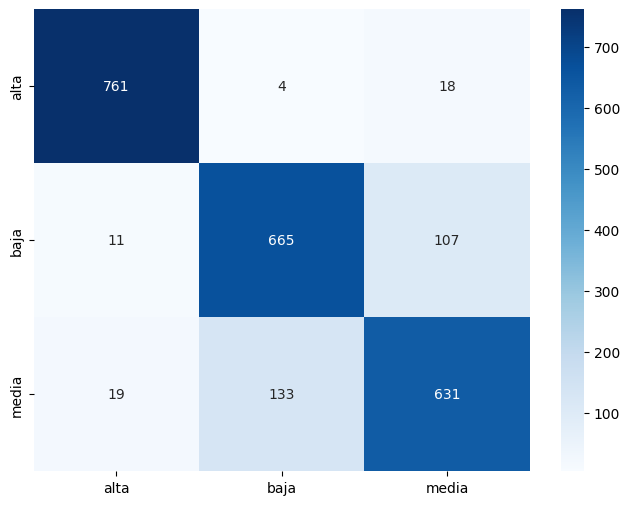

In [76]:
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(
    cm_rf_abc, 
    annot=True, 
    fmt='d',          # 'd' = formato entero (sin decimales)
    cmap='Blues',     # Colores azules (puedes usar 'Reds', 'Greens', etc.)
    cbar=True,        # Muestra la barra de colores lateral
    xticklabels=['alta', 'baja', 'media'],  # Nombres de clases (¡ajústalos!)
    yticklabels=['alta', 'baja', 'media'] # Nombres de clases
)